# **Linear Regression**

In [0]:
%tensorflow_version 2.x

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import optimizers

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Deep Learning'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Deep Learning


In [0]:
train = pd.read_csv("housing_train.csv")
test = pd.read_csv("housing_test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#log transform the target y in training data - by reference inside all
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:

# Get Numerical Fields
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index 

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewnessc
skewed_feats = skewed_feats[skewed_feats > 0.75] # Get Skewed Columns
skewed_feats = skewed_feats.index # Get Skewed Columns indices

#log scale skewed columns
# normalize the skewed distribution for better regression
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# Create Dummy variables for the categorical features
all_data = pd.get_dummies(all_data)

# Replace the numeric missing values (NaN's) with the mean of their respective columns
all_data = all_data.fillna(all_data.mean())

#splitting the data to training & testing
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

# Standardize features by removing the mean and scaling to unit variance
# z = (x - u) / s
X_train = StandardScaler().fit_transform(X_train)

#split training data into training & validation, default splitting is 25% validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [0]:
## TODO START CODE HERE, Writing the Model using Tensorflow.Keras is a must
model = Sequential()
model.add(Dense(1, input_dim=288, kernel_initializer='random_uniform', activation='linear'))
## TODO END CODE HERE

sgd = tf.keras.optimizers.SGD(lr =0.01, momentum=0.001)
model.compile(loss = "mean_squared_error", optimizer =sgd)
model.summary()

hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val), epochs = 500)
print(model.predict(X_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Train on 1095 samples, validate on 365 samples
Epoch 1/500
1095/1095 [==============================] - 0s 235us/sample - loss: 89.8049 - val_loss: 49.5837
Epoch 2/500
1095/1095 [==============================] - 0s 59us/sample - loss: 20.3817 - val_loss: 21.2797
Epoch 3/500
1095/1095 [==============================] - 0s 57us/sample - loss: 5.1195 - val_loss: 11.9301
Epoch 4/500
1095/1095 [==============================] - 0s 57us/sample - loss: 1.5116 - val_loss: 8.9896
Epoch 5/500
1095/1095 [==============================] - 0s 56us/sample - loss: 0.5603 - val_loss: 7.9162
Epoch 6/500
1095/1095 [==============================] - 0s 56us/sa

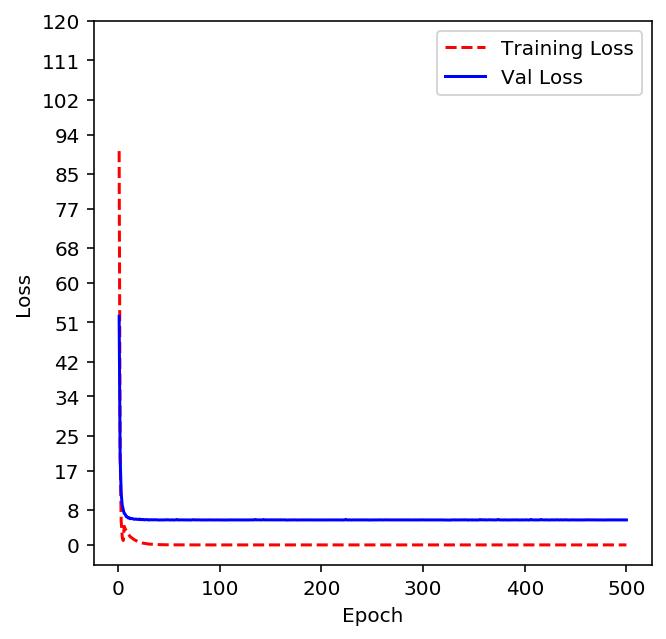

In [0]:
# Get training and test loss histories
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=[5,5])
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks(np.floor(np.linspace(0, 120, 15)))
plt.show()

# **Logistic Regression**

In [0]:
%tensorflow_version 2.x

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.initializers import RandomNormal, RandomUniform
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalHinge, MeanSquaredError
from tensorflow.keras import regularizers
from sklearn import preprocessing

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Deep Learning'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Deep Learning


In [0]:
dataset = pd.read_csv("heart.csv")

In [0]:
# Check if data is skewed
dataset[list(dataset.columns)].apply(lambda x: skew(x.dropna()))

age        -0.201460
sex        -0.787412
cp          0.482329
trestbps    0.710230
chol        1.137733
fbs         1.976803
restecg     0.161717
thalach    -0.534746
exang       0.738851
oldpeak     1.263426
slope      -0.505796
ca          1.303926
thal       -0.474359
target     -0.178930
dtype: float64

In [0]:
# Check if there are missing values
dataset.isnull().values.any()

False

In [0]:
poly = preprocessing.PolynomialFeatures(2)
art_features = poly.fit_transform(dataset.iloc[:, 0:13].values)
art_features.shape

(303, 105)

In [0]:
X = dataset.iloc[:, 0:13].values
y = dataset.iloc[:, 13].values

## TODO START:: Data Pre-Processing

X = StandardScaler().fit_transform(X)

## TODO End:: Data Pre-Processing

# Get Training Data
train_X, temporary_X, train_y, temporary_y = train_test_split(X, y, train_size=0.75, random_state=0)

# Get Validation & Testing Data
val_X, test_X, val_y, test_y = train_test_split(temporary_X, temporary_y, train_size=0.5, random_state=0)

**Highest Test accuracy**

Train on 227 samples, validate on 38 samples
Epoch 1/1000
227/227 [==============================] - 0s 2ms/sample - loss: 0.9398 - accuracy: 0.7533 - val_loss: 0.8999 - val_accuracy: 0.7895
Epoch 2/1000
227/227 [==============================] - 0s 162us/sample - loss: 0.8577 - accuracy: 0.8238 - val_loss: 0.8176 - val_accuracy: 0.7632
Epoch 3/1000
227/227 [==============================] - 0s 147us/sample - loss: 0.7828 - accuracy: 0.8370 - val_loss: 0.7583 - val_accuracy: 0.7895
Epoch 4/1000
227/227 [==============================] - 0s 155us/sample - loss: 0.7317 - accuracy: 0.8370 - val_loss: 0.7221 - val_accuracy: 0.8158
Epoch 5/1000
227/227 [==============================] - 0s 158us/sample - loss: 0.6989 - accuracy: 0.8370 - val_loss: 0.7022 - val_accuracy: 0.8421
Epoch 6/1000
227/227 [==============================] - 0s 153us/sample - loss: 0.6770 - accuracy: 0.8326 - val_loss: 0.6908 - val_accuracy: 0.8421
Epoch 7/1000
227/227 [==============================] - 0s 146us/samp

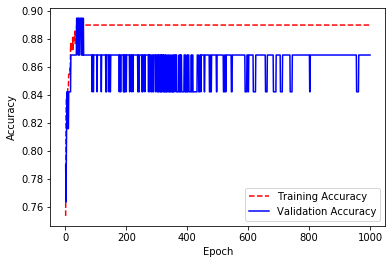

In [0]:

## TODO START:: Model Definition, Writing the Model using Tensorflow.Keras is a must
model = Sequential()
model.add(Dense(1, input_dim=13, kernel_initializer='random_uniform', activation='sigmoid'))

## TODO END:: Model Definition

## TODO Try Different losses & optimizers here
rmsprop = RMSprop(lr = 0.01)
model.compile(loss=CategoricalHinge(), metrics=['accuracy'], optimizer=rmsprop)
hist = model.fit(train_X, train_y, verbose=1, validation_data=(val_X, val_y), batch_size=16, epochs=1000)
score, accuracy = model.evaluate(test_X, test_y, batch_size=16, verbose=0)

print("Test fraction correct (NN-Score) = {:.2f}".format(score))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

# Get training and test loss histories
training_loss = hist.history['accuracy']
val_loss = hist.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure()
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

**Highest Validation accuracy**

In [0]:
X = art_features
y = dataset.iloc[:, 13].values

## TODO START:: Data Pre-Processing

X = StandardScaler().fit_transform(X)

## TODO End:: Data Pre-Processing

# Get Training Data
train_X, temporary_X, train_y, temporary_y = train_test_split(X, y, train_size=0.75, random_state=0)

# Get Validation & Testing Data
val_X, test_X, val_y, test_y = train_test_split(temporary_X, temporary_y, train_size=0.5, random_state=0)

Train on 227 samples, validate on 38 samples
Epoch 1/500
227/227 [==============================] - 1s 2ms/sample - loss: 0.9220 - accuracy: 0.7974 - val_loss: 0.8557 - val_accuracy: 0.8158
Epoch 2/500
227/227 [==============================] - 0s 180us/sample - loss: 0.7441 - accuracy: 0.8502 - val_loss: 0.7378 - val_accuracy: 0.8158
Epoch 3/500
227/227 [==============================] - 0s 174us/sample - loss: 0.6556 - accuracy: 0.8502 - val_loss: 0.6977 - val_accuracy: 0.8158
Epoch 4/500
227/227 [==============================] - 0s 151us/sample - loss: 0.6348 - accuracy: 0.8546 - val_loss: 0.6946 - val_accuracy: 0.8158
Epoch 5/500
227/227 [==============================] - 0s 157us/sample - loss: 0.6264 - accuracy: 0.8590 - val_loss: 0.6876 - val_accuracy: 0.8158
Epoch 6/500
227/227 [==============================] - 0s 157us/sample - loss: 0.6193 - accuracy: 0.8634 - val_loss: 0.6800 - val_accuracy: 0.8158
Epoch 7/500
227/227 [==============================] - 0s 149us/sample - lo

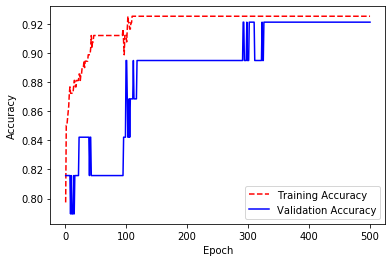

In [0]:
## TODO START:: Model Definition, Writing the Model using Tensorflow.Keras is a must
model = Sequential()
model.add(Dense(1, input_dim=105, kernel_initializer='random_uniform', activation='sigmoid'))

## TODO END:: Model Definition

## TODO Try Different losses & optimizers here
adam = Adam(lr = 0.01)
model.compile(loss=CategoricalHinge(), metrics=['accuracy'], optimizer=adam)
hist = model.fit(train_X, train_y, verbose=1, validation_data=(val_X, val_y), batch_size=16, epochs=500)
score, accuracy = model.evaluate(test_X, test_y, batch_size=16, verbose=0)

print("Test fraction correct (NN-Score) = {:.2f}".format(score))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

# Get training and test loss histories
training_loss = hist.history['accuracy']
val_loss = hist.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure()
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()